In [35]:
"""
Description: This code uses an Artificial RNN (LSTM: Long Short Term Memory Architecture) to predict the
closing cryptocurrency price.
We use RNN as we are processing a sequence of data, and not standalone data points.
"""
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("fivethirtyeight")

In [36]:
df = pd.read_csv("cryptocurrencies_combined_daily.csv")
df = df[df['Cryptocurrency'] == "Ripple"]
df

,Date,Open,High,Low,Close,Adj Close,Volume,Cryptocurrency
3654,2019-08-15,0.263707,0.268241,0.256112,0.264882,0.264882,1342788578,Ripple
3655,2019-08-16,0.265075,0.265452,0.256977,0.261971,0.261971,1133224404,Ripple
3656,2019-08-17,0.261885,0.268046,0.259252,0.265721,0.265721,1004931822,Ripple
3657,2019-08-18,0.265714,0.288718,0.263579,0.282646,0.282646,1216547019,Ripple
3658,2019-08-19,0.282290,0.289091,0.278425,0.283328,0.283328,1241578947,Ripple
...,...,...,...,...,...,...,...,...
5476,2024-08-10,0.581151,0.601367,0.579598,0.585579,0.585579,1134054567,Ripple
5477,2024-08-11,0.585586,0.593077,0.547541,0.552932,0.552932,1202704291,Ripple
5478,2024-08-12,0.552931,0.579069,0.552163,0.568768,0.568768,1479740403,Ripple
5479,2024-08-13,0.568768,0.583113,0.563872,0.576399,0.576399,1245896255,Ripple


In [37]:
df.to_csv('Ripple_Data.csv',index=False)

In [38]:
# Create a new dataframe with only the "Close" column.
data = df.filter(["Close"])

dataset = data.values

training_data_len = int(math.ceil(0.75 * len(dataset)))

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.073692  ],
       [0.07197925],
       [0.07418564],
       ...,
       [0.25249045],
       [0.25698033],
       [0.2527399 ]])

In [39]:
"""
Training the model.
"""
# Create the scaled training dataset.
train_data = scaled_data[:training_data_len, :]

x_train, y_train = [], []
d = 120
# Append the past 120 day values.
for i in range(d, len(train_data)):
    x_train.append(train_data[i - d:i, 0])
    y_train.append(train_data[i, 0])
"""
x_train array contains the past 120 days value of the closing price.
y_train contains the 121st value that we want our model to be able to predict based on those
past 120 day closing prices.
"""
print(x_train[0])
print(y_train[0])

[0.073692   0.07197925 0.07418564 0.08414387 0.08454514 0.0801194
 0.07450338 0.07725872 0.08055419 0.07820541 0.07675507 0.07716694
 0.07647854 0.06931922 0.06908092 0.06859433 0.07035122 0.06967458
 0.07130203 0.07266647 0.07076367 0.06866964 0.06631262 0.07122377
 0.0726341  0.07056185 0.07003761 0.06844018 0.06776649 0.0682019
 0.07150619 0.07177744 0.07137969 0.08553654 0.10245992 0.09579072
 0.0911008  0.08814303 0.08195806 0.0759237  0.0562432  0.06284181
 0.0612785  0.06141794 0.0605648  0.05986875 0.06842664 0.06467989
 0.06701808 0.06367671 0.06725108 0.06696984 0.06946925 0.08004821
 0.08168036 0.08354431 0.077923   0.07734992 0.0785808  0.08127202]
0.0923087276756919


In [40]:
# Convert the x_train and y_train dataset to NumPy arrays.
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train dataset.
"""
LSTM Network expects the data to be 3-D: Number of samples, timestamps, features.
"""
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [41]:
# Build the LSTM Model Architecture.
model = Sequential()

model.add(LSTM(125, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(LSTM(100, return_sequences=True))
model.add(LSTM(70, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

In [42]:
# Compile the model.
model.compile(optimizer="adam", loss="mean_absolute_error")
# Train the model.
"""
No. of forward and backward passes for backpropagation algorithm = 1.
Batch size = 1.
"""
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
263/263 [==============================] - 46s 116ms/step - loss: 0.0567
Epoch 2/5
263/263 [==============================] - 31s 119ms/step - loss: 0.0357
Epoch 3/5
263/263 [==============================] - 32s 120ms/step - loss: 0.0329
Epoch 4/5
263/263 [==============================] - 31s 117ms/step - loss: 0.0256
Epoch 5/5
263/263 [==============================] - 32s 120ms/step - loss: 0.0231


In [43]:
# Create the testing dataset.
test_data = scaled_data[training_data_len - d:, :]  
# Create the datasets x_test and y_test.
x_test = []
y_test = dataset[training_data_len:, :]  

for i in range(d, len(test_data)):
    x_test.append(test_data[i - d:i, 0])  

# Convert the data to a NumPy array
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test.shape)

# Get the model's predicted price values.
predictions = model.predict(x_test)

# Unscale the values to compare the predictions.
predictions = scaler.inverse_transform(predictions)


(456, 60, 1)
15/15 [==============================] - 3s 54ms/step


In [44]:
# Evaluation of the model using RMSE Error.
mae = np.mean(np.abs(predictions - y_test))
mae

0.019153324527698655

Epoch 1/5
273/273 [==============================] - 15s 16ms/step - loss: 0.0421
Epoch 2/5
273/273 [==============================] - 5s 17ms/step - loss: 0.0341
Epoch 3/5
273/273 [==============================] - 5s 17ms/step - loss: 0.0336
Epoch 4/5
273/273 [==============================] - 5s 17ms/step - loss: 0.0317
Epoch 5/5
15/15 [==============================] - 2s 7ms/step
Epoch 1/5
273/273 [==============================] - 16s 22ms/step - loss: 0.0485
Epoch 2/5
273/273 [==============================] - 6s 23ms/step - loss: 0.0366
Epoch 3/5
273/273 [==============================] - 7s 26ms/step - loss: 0.0375
Epoch 4/5
273/273 [==============================] - 7s 25ms/step - loss: 0.0354
Epoch 5/5
15/15 [==============================] - 2s 11ms/step
Epoch 1/5
269/269 [==============================] - 27s 54ms/step - loss: 0.0537
Epoch 2/5
269/269 [==============================] - 14s 53ms/step - loss: 0.0368
Epoch 3/5
269/269 [==============================] - 15s 56

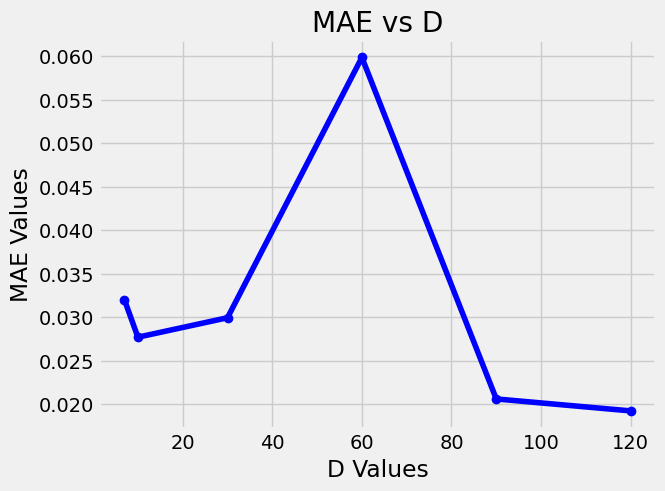

In [45]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

"""This code is designed to find the optimal value for d—the number of past days used to predict the next closing price in a time series model using an LSTM architecture.
It iterates over a set of different d values (7, 10, 30, 60, 90, 120), trains an LSTM model for each value of d, and evaluates its performance using Mean Absolute Error (MAE). """


d_values = [7, 10, 30, 60, 90, 120]
mae_values = []

for d in d_values:
    # Load the dataset
    df = pd.read_csv("cryptocurrencies_combined_daily.csv")
    df = df[df['Cryptocurrency'] == "Ripple"]

    if df.empty:
        print(f"No data available for Ethereum after filtering for d = {d}. Skipping this iteration.")
        continue

    # Create a new dataframe with only the "Close" column
    data = df.filter(["Close"])

    dataset = data.values

    if len(dataset) == 0:
        print(f"No data available in the dataset for d = {d}. Skipping this iteration.")
        continue

    training_data_len = int(math.ceil(0.75 * len(dataset)))

    # Data preprocessing
    scaler = MinMaxScaler(feature_range=(0, 1))

    if training_data_len == 0:
        print(f"Not enough data to split for training for d = {d}. Skipping this iteration.")
        continue

    scaled_data = scaler.fit_transform(dataset)

    # Training the model
    train_data = scaled_data[:training_data_len, :]

    x_train, y_train = [], []
    for i in range(d, len(train_data)):
        x_train.append(train_data[i - d:i, 0])
        y_train.append(train_data[i, 0])

    # Check if x_train and y_train contain data
    if len(x_train) == 0 or len(y_train) == 0:
        print(f"No training data available for d = {d}. Skipping this iteration.")
        continue

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build the LSTM Model Architecture
    model1 = Sequential()
    model1.add(LSTM(125, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model1.add(LSTM(100, return_sequences=True))
    model1.add(LSTM(70, return_sequences=True))
    model1.add(LSTM(50, return_sequences=True))
    model1.add(LSTM(30, return_sequences=False))

    model1.add(Dense(25))
    model1.add(Dense(1))

    # Compile the model
    model1.compile(optimizer="adam", loss="mean_absolute_error")

    # Train the model
    model1.fit(x_train, y_train, batch_size=5, epochs=5)

    # Create the testing dataset
    test_data = scaled_data[training_data_len - d:, :]

    # Create the datasets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(d, len(test_data)):
        x_test.append(test_data[i - d:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    if len(x_test) == 0:
        print(f"No testing data available for d = {d}. Skipping this iteration.")
        continue

    predictions = model1.predict(x_test)

    predictions = scaler.inverse_transform(predictions)

    # Evaluation of the model using MAE Error
    mae = np.mean(np.abs(predictions - y_test))
    mae_values.append(mae)

# Plot the MAE values against d_values
plt.plot(d_values, mae_values, marker='o', linestyle='-', color='b')

plt.title('MAE vs D')
plt.xlabel('D Values')
plt.ylabel('MAE Values')


plt.grid(True)
plt.show()


In [46]:
with open('Ripple.pkl','wb') as file:
   # pickle.dump(model, file)

In [47]:
import pickle

C:\Users\uttka\AppData\Local\Temp\ipykernel_23832\1287827500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


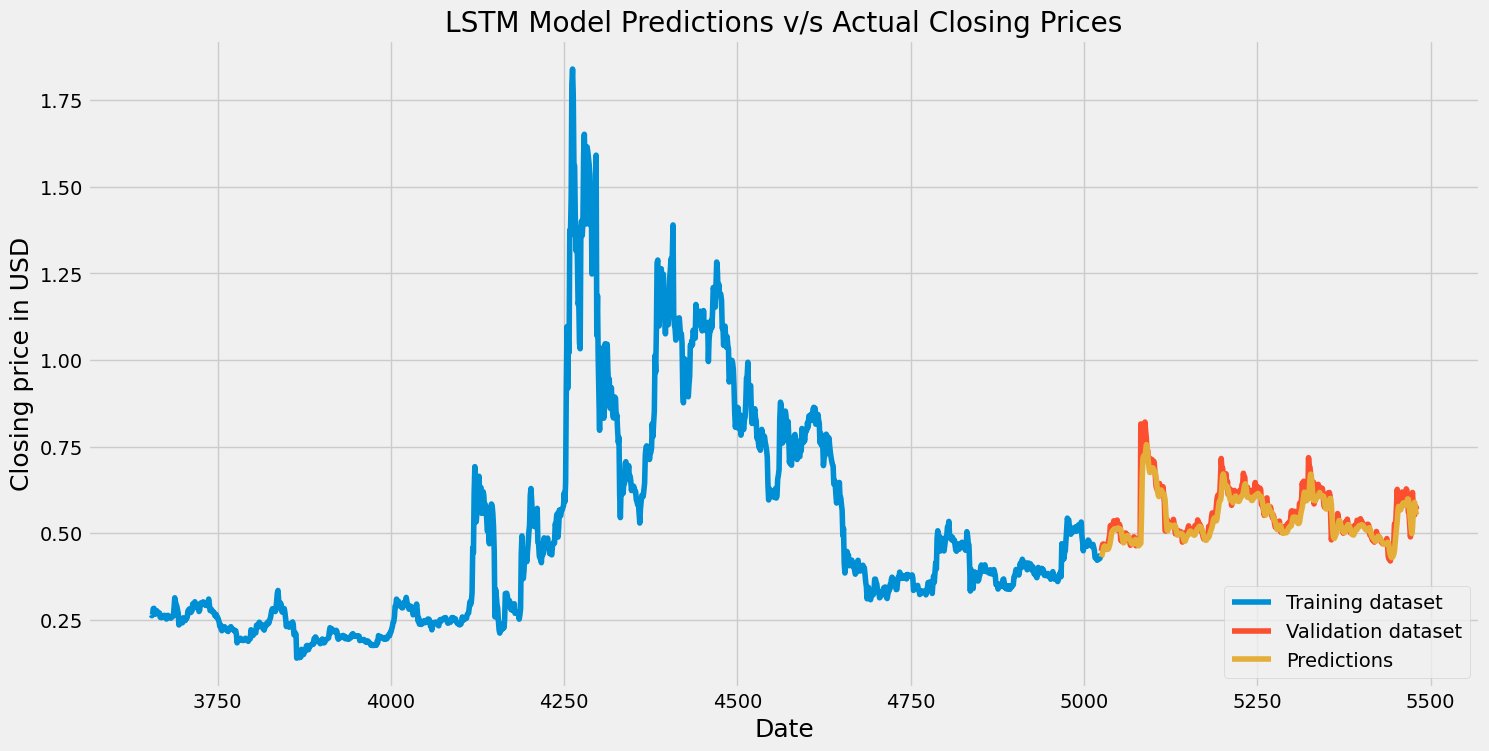

In [48]:
# Plot the data.
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions

plt.figure(figsize=(16, 8))
plt.title("LSTM Model Predictions v/s Actual Closing Prices")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing price in USD", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Training dataset", "Validation dataset", "Predictions"], loc="lower right")
plt.show()
plt.savefig('Ripple.png')
plt.close()

In [49]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 60, 125)           63500     
                                                                 
 lstm_101 (LSTM)             (None, 60, 100)           90400     
                                                                 
 lstm_102 (LSTM)             (None, 60, 70)            47880     
                                                                 
 lstm_103 (LSTM)             (None, 60, 50)            24200     
                                                                 
 lstm_104 (LSTM)             (None, 30)                9720      
                                                                 
 dense_40 (Dense)            (None, 25)                775       
                                                                 
 dense_41 (Dense)            (None, 1)               

In [50]:
valid.to_csv('Ripple_pred.csv', index=False)

In [51]:
valid

,Close,Predictions
5025,0.448589,0.431452
5026,0.460299,0.437412
5027,0.467982,0.445789
5028,0.469081,0.454900
5029,0.457550,0.462009
...,...,...
5476,0.585579,0.582915
5477,0.552932,0.589028
5478,0.568768,0.574928
5479,0.576399,0.559268
